# One-Shot Learning of Omniglot Dataset with First-Order MAML 

This notebook explores one-shot learning of Omniglot Dataset using MAML (Model-Agnostic Meta-Learning). 

## Overview

Artificial intelligence is trying to learn how to learn from the way humans learn. We can quickly and easily recognize a new object from just seeing one or few pictures of it, or even from only reading about it without having ever seen it before. We can learn quickly a new skill as well as master many different tasks. This seems easy for the human intelligence but for machines, it is quite a challenge to overcome. Can machine learning do better?

## One-Shot Learning

Conventional wisdom says that deep neural networks are really good at learning from high dimensional data like images or spoken language, but only when they have huge amounts of labelled examples to train on. Humans on the other hand, are capable of **one-shot learning** - if you take a human who’s never seen a bird before, and show them a single picture of a bird, they will probably be able to distinguish birds from other animals with astoundingly high precision. We want machines to also learn and perform tasks in **One Shot Learning**

## Meta Learning

Best put, **Learning to Learn** is Meta Learning.Deep learning has a great success in mastering one task using a large dataset. In meta-learning, there is a meta-learner and a learner. The meta-learner (or the agent) trains the learner (or the model) on a training set that contains a large number of different tasks. We really want to achieve Few-Shot Meta Learning, an algorithm that trains a neural network to learn many different tasks using only a small data per task.

## MAML(Model-Agnostic Meta Learning)

Model-Agnostic ~  Model Independent 

MAML, short for Model-Agnostic Meta-Learning is a fairly general optimization algorithm, compatible with any model that learns through gradient descent. MAML does not learn on batches of samples like most deep learning algorithms but batches of tasks AKA meta-batches. For each task in a meta-batch we first initialise a new “fast model” using the weights of the base meta-learner. We then compute the gradient and hence a parameter update from samples drawn from that task and update the weights of the fast model i.e. perform typical mini-batch stochastic gradient descent on the weights of the "fast model".The brilliance of this approach is that it can not only work for supervised regression and classification problems but also for reinforcement learning using any differentiable model!

>**First-Order MAML**

> To make the computation less expensive, a modified version of MAML omits second derivatives, resulting in a simplified and cheaper implementation, known as First-Order MAML (FOMAML).

For this one-shot learning problem, we are going to use First-Order MAML.

## Omniglot Dataset

Omniglot dataset is a collection of 1623 hand drawn characters from 50 alphabets. For every character there are just 20 examples, each drawn by a different person at resolution 105x105.

<img src="https://cdn-images-1.medium.com/max/1600/1*fRd4Sc6cT0_KFm6IhB3Bqw.png"></img>








# Let's get started!

Let us structure the whole code , so that it would it easier to understand. This is how we are going to break it down. 

## Mount Goolge Drive to Colab

If using Google Colab, mount the drive and go to the repository.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

In [2]:
cd '/content/drive/My Drive/One-Shot Learning'

## Import Dependencies

In [4]:
#Importing all the necessary libraries
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import itertools
import tensorflow as tf
import cv2

C:\Users\Aditya Gannavarapu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Preparing our Dataset

[Omniglot](https://https://github.com/brendenlake/omniglot). 

Download and Extract: 

Background set of [30 alphabets](https://https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip) for training and save it in 'train' folder.

Evaluation on set of [20 alphabets](https://https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip) for testing and save it in 'test' folder



In [5]:
train_dir = 'train' #Directory for training samples 
test_dir = 'test' #Directory for testing samples

## Initialize required arguments

In [6]:
args = {
"shots":1, #Number of shots for Meta-Learning (1-shot)
"classes":20, #Number of classes in the sample (20-way)
"learning_rate":0.0005,# Learning Rate
    
#Meta-Training arguments
"train_shots":10, # Shots in a training batch
"meta_batch":5, # Batch size for Meta-training
"meta_iters":20000, # Iteration for Meta-training
"meta_step":1.0,# Meta-Training step size
"meta_step_final":0.0, # Meta-Training step size at the end
    
#Inner Loop Training arguments
"inner_batch":20, # Inner Batch size for train step
"inner_iters":10, # Inner Iteration for train step
    
#Evaluation arguments
"eval_batch":10, #Inner Batch size for evaluation
"eval_interval":10, #Train steps for evaluation
"eval_iters":50, #Inner Iterations for evaluation
"eval_samples":10000,# Evaluation Samples
    
#FOML
"foml_tail":None, # Declare tail-shots for FOML
"pretrained":False, 
"replacement":False, # Replacement of Sample data
"seed":0, # Random seed

"transductive":False, # Flag to evaluate all the samples at once
"weight_decay":1 # Rate of decay of weights
}

## Helper Functions

* Helper function to plot images in a row
*   Helper Functions for variable manipulation
*   Helper Functions to read and augment our dataset
* Helper Functions for returning (key,value) pair arguments (kwargs)





### Helper function to plot images in a row

In [326]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

### Helper functions to  read and augment our dataset

#### Character Class 

In [7]:
#We will declare a class Character for every character in training and testing samples making it easy to read and visualize.

#A single character class.

class Character:
    def __init__(self, dir_path, rotation=0):
        self.dir_path = dir_path
        self.rotation = rotation
        self._cache = {}

    def sample(self, num_images):
      
        """
        Sample images (as numpy arrays) from the class.
        A sequence of 28x28 numpy arrays.
        """
        
        names = [f for f in os.listdir(self.dir_path) if f.endswith('.png')]
        random.shuffle(names)
        images = []
        for name in names[:num_images]:
            images.append(self._read_image(os.path.join(self.dir_path, name)))
        return images

    def _read_image(self, path):
      
        """
        Read images from the given path.
        28x28 numpy arrays. Each pixel ranges from 0 to 1.
        """
        
        if path in self._cache:
            return self._cache[path]
        with open(path, 'rb') as in_file:
            img = Image.open(in_file).resize((28, 28)).rotate(self.rotation)
            self._cache[path] = np.array(img).astype('float32')
            return self._cache[path]

#### Functions to read and augment the dataset

In [8]:
# Iterate over the characters in a data directory and read them..

def read_dataset(data_dir):
    for alphabet_name in sorted(os.listdir(data_dir)):
        alphabet_dir = os.path.join(data_dir, alphabet_name)
        if not os.path.isdir(alphabet_dir):
            continue
        for char_name in sorted(os.listdir(alphabet_dir)):
            if not char_name.startswith('character'):
                continue
            yield Character(os.path.join(alphabet_dir, char_name), 0)

#Augment the dataset by adding 90 degree rotations.

def augment_dataset(dataset):
    for character in dataset:
        for rotation in [0, 90, 180, 270]:
            yield Character(character.dir_path, rotation=rotation)

### Helper functions for variable manipulation

We create a class called VariableState to manage the state and to save and restore session variables.

In [9]:
def interpolate(old_vars, new_vars, epsilon):
    """
    Interpolate between two sequences of variables.
    """
    return add(old_vars, scale(subtract(new_vars, old_vars), epsilon))

def average(var_seqs):
    """
    Average a sequence of variable sequences.
    """
    res = []
    for variables in zip(*var_seqs):
        res.append(np.mean(variables, axis=0))
    return res

def subtract(var_seq_1, var_seq_2):
    """
    Subtract one variable sequence from another.
    """
    return [v1 - v2 for v1, v2 in zip(var_seq_1, var_seq_2)]

def add(var_seq_1, var_seq_2):
    """
    Add two variable sequences.
    """
    return [v1 + v2 for v1, v2 in zip(var_seq_1, var_seq_2)]

def scale(var_seq, scale):
    """
    Scale a variable sequence.
    """
    return [v * scale for v in var_seq]
  
def weight_decay(rate, variables=None):
    """
    Create an Op that performs weight decay.
    """
    if variables is None:
        variables = tf.trainable_variables()
    ops = [tf.assign(var, var * rate) for var in variables]
    return tf.group(*ops)

class VariableState:
    """
    Manage the state of a set of variables.
    """
    def __init__(self, session, variables):
        self._session = session
        self._variables = variables
        self._placeholders = [tf.placeholder(v.dtype.base_dtype, shape=v.get_shape()) for v in variables]
        assigns = [tf.assign(v, p) for v, p in zip(self._variables, self._placeholders)]
        self._assign_op = tf.group(*assigns)

    def export_variables(self):
        """
        Save the current variables.
        """
        return self._session.run(self._variables)

    def import_variables(self, values):
        """
        Restore the variables.
        """
        self._session.run(self._assign_op, feed_dict=dict(zip(self._placeholders, values)))

### Helper Functions for returning (key,value) pair arguments  (kwargs)

In [101]:
#Declare helper functions to build kwargs

def model_kwargs(args):
    """
    Build the kwargs for model constructors.
    """
    res = {'learning_rate': args['learning_rate']}
    return res
  
def train_kwargs(args):
    """
    Build kwargs for the train() function.
    """
    return {
        'num_classes': args['classes'],
        'num_shots': args['shots'],
        'train_shots': (args['train_shots'] or None),
        'inner_batch_size': args['inner_batch'],
        'inner_iters': args['inner_iters'],
        'replacement': args['replacement'],
        'meta_step_size': args['meta_step'],
        'meta_step_size_final': args['meta_step_final'],
        'meta_batch_size': args['meta_batch'],
        'meta_iters': args['meta_iters'],
        'eval_inner_batch_size': args['eval_batch'],
        'eval_inner_iters': args['eval_iters'],
        'eval_interval': args['eval_interval'],
        'weight_decay_rate': args['weight_decay'],
        'transductive': args['transductive'],
        'model_fn': _args_model(args)
    }

  
def evaluate_kwargs(args):
    """
    Build kwargs for the evaluate() function.
    """
    return {
        'num_classes': args['classes'],
        'num_shots': args['shots'],
        'eval_inner_batch_size': args['eval_batch'],
        'eval_inner_iters': args['eval_iters'],
        'replacement': args['replacement'],
        'weight_decay_rate': args['weight_decay'],
        'num_samples': args['eval_samples'],
        'transductive': args['transductive'],
        'model_fn': _args_model(args)
    }

def _args_model(args):
    """
    This return the FOML class (First-Order MAML)
    """
    return partial(FOML, tail_shots=args['foml_tail'])

## Defining our Model

We create a class OmniglotModel to define our model. 

In [11]:
# We are going to use Adam optimizer as our default optimzer.
DEFAULT_OPTIMIZER = partial(tf.train.AdamOptimizer, beta1=0)

#A model for Omniglot classification.
class OmniglotModel:
    def __init__(self, num_classes, optimizer=DEFAULT_OPTIMIZER, **optim_kwargs):
        
        """
        Create input and label placeholders.Structure the model.
        model.summary gives you an overview of the model
        """
        self.input_ph = tf.placeholder(tf.float32, shape=(None, 28, 28))
        out = tf.reshape(self.input_ph, (-1, 28, 28, 1))
        self.summary = []
        self.summary.append(out)
        for _ in range(4):
            out = tf.layers.conv2d(out, 64, 3, strides=2, padding='same')
            self.summary.append(out)
            out = tf.layers.batch_normalization(out, training=True)
            self.summary.append(out)
            out = tf.nn.relu(out)
            self.summary.append(out)
        out = tf.reshape(out, (-1, int(np.prod(out.get_shape()[1:]))))
        self.summary.append(out)
        self.logits = tf.layers.dense(out, num_classes)
        self.summary.append(self.logits)
        self.label_ph = tf.placeholder(tf.int32, shape=(None,))
        self.loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.label_ph,
                                                                   logits=self.logits)
        self.predictions = tf.argmax(self.logits, axis=-1)
        self.minimize_op = optimizer(**optim_kwargs).minimize(self.loss)

## First-Order MAML implementation

We'll approch this implementation in two steps

*   Creating helper functions

*   Declaring a class FOML.




### Creating helper functions

In [12]:
"""
    _mini_batches():
    
    This fucntion generates mini-batches from data.

    Returns:
      An iterable of sequences of (input, label) pairs,
        where each sequence is a mini-batch.
    """
def _mini_batches(samples, batch_size, num_batches, replacement):
    samples = list(samples)
    if replacement:
        for _ in range(num_batches):
            yield random.sample(samples, batch_size)
        return
    cur_batch = []
    batch_count = 0
    while True:
        random.shuffle(samples)
        for sample in samples:
            cur_batch.append(sample)
            if len(cur_batch) < batch_size:
                continue
            yield cur_batch
            cur_batch = []
            batch_count += 1
            if batch_count == num_batches:
                return

"""
    _sample_mini_dataset_():
    
    This function creates a few shot task from the dataset, given number of shots and classes. .

    Returns:
      An iterable of (input, label) pairs.
    """

def _sample_mini_dataset(dataset, num_classes, num_shots):
   
    shuffled = list(dataset)
    random.shuffle(shuffled)
    for class_idx, class_obj in enumerate(shuffled[:num_classes]):
        for sample in class_obj.sample(num_shots):
            yield (sample, class_idx)
            
"""
    _split_train_test():
    
    This fucntion splits a few-shot task into a train and a test set, given an iterable of (input, label) pairs.
    test_shots: the number of examples per class in the test set.

    Returns:
      A tuple (train, test), where train and test are
        sequences of (input, label) pairs.
    """
def _split_train_test(samples, test_shots=1):
    train_set = list(samples)
    test_set = []
    labels = set(item[1] for item in train_set)
    for _ in range(test_shots):
        for label in labels:
            for i, item in enumerate(train_set):
                if item[1] == label:
                    del train_set[i]
                    test_set.append(item)
                    break
    if len(test_set) < len(labels) * test_shots:
        raise IndexError('not enough examples of each class for test set')
    return train_set, test_set

### Declaring a class FOML (FOML implementation) 

Let's break this down. (Please check comments in the code for respective steps)

Please refer to 'Helper functions for variable manipulation' in Helper Functions section to know about the functions used in this section.



*   Step 1 - Initialize a session of FOML
*   Step 2 -  In the train_step, we initialize old variables from model state and new variables array to save them.
* Step 3 - Looping through our meta bacth size, we create a mini dataset from the dataset according to number of classes and shots.
* Step 4 - Now we create mini-batches from this mini dataset created.
* Step 5 - For every batch in mini batches, take input, labels from batch and run the session on our minimize_op from model (Adam Optimizer).
* Step 6 - Once it is done, we append the model's state varibales into the new_vars array.
* Step 7 - Restore the state variables for next iteration.
* Step 8 -  Once all the training set is looped through the meta bacth size, we take an average of all the new variables saved until now.
* Step 9 -  We perform update of state variables by interpolating the old and new variables with meta step size.


In [105]:
"""
    A basic implementation of "first-order MAML" (FOML).

    FOML uses the gradient from the last mini-batch as the update
    direction.

    There are two ways to sample batches for FOML.
    By default, FOML samples batches such that final mini-batch may overlap with
    the previous mini-batches.
    Alternatively, if tail_shots is specified, then a
    separate mini-batch is used for the final step.
    This final mini-batch is guaranteed not to overlap
    with the training mini-batches.
    
    
    It can operate in two evaluation modes: normal
    and transductive. In transductive mode, information is
    allowed to leak between test samples via BatchNorm.
    Typically, MAML is used in a transductive manner.
    """

class FOML():

    def __init__(self, session, variables=None, transductive=False, pre_step_op=None, tail_shots=None):
      
        #STEP-1
        """
        Create a first-order MAML session.

        Args:
          tail_shots: if specified, this is the number of
            examples per class to reserve for the final
            mini-batch.
          pre_step_op : if specified, this is the pre-step operation we do,which is generally the weight decay.
          transductive : this is to specify to evaluate all samples at once.
        """
        self.session = session
        self._model_state = VariableState(self.session, variables or tf.trainable_variables())
        self._full_state = VariableState(self.session, tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
        self._transductive = transductive
        self._pre_step_op = pre_step_op
        self.tail_shots = tail_shots
        
    #This is the training function for each step which takes the dataset create mini batches and train them.
    #Also updates the weights to model state.

    def train_step(self,
                   dataset,
                   input_ph,
                   label_ph,
                   minimize_op,
                   num_classes,
                   num_shots,
                   inner_batch_size,
                   inner_iters,
                   replacement,
                   meta_step_size,
                   meta_batch_size):
        #STEP-2
        old_vars = self._model_state.export_variables()
        new_vars = []
        for _ in range(meta_batch_size):
            #STEP-3
            mini_dataset = _sample_mini_dataset(dataset, num_classes, num_shots)
            #STEP-4
            mini_batches = _mini_batches(mini_dataset, inner_batch_size, inner_iters,
                                              replacement)
            #STEP-5
            for batch in mini_batches:
                inputs, labels = zip(*batch)
                if self._pre_step_op:
                    self.session.run(self._pre_step_op)
                self.session.run(minimize_op, feed_dict={input_ph: inputs, label_ph: labels})
            #STEP-6
            new_vars.append(self._model_state.export_variables())
            #STEP-7
            self._model_state.import_variables(old_vars)
        #STEP-8
        new_vars = average(new_vars)
        #STEP-9
        self._model_state.import_variables(interpolate(old_vars,new_vars,meta_step_size))
        
    
    def _mini_batches(self, mini_dataset, inner_batch_size, inner_iters, replacement):
        """
        Generate inner-loop mini-batches for the task.
        """
        if self.tail_shots is None:
            #This call the external _mini_batch function if tail_shots is none.
            for value in _mini_batches(mini_dataset, inner_batch_size, inner_iters, replacement):
                yield value
            return
        train, tail = _split_train_test(mini_dataset, test_shots=self.tail_shots)
        for batch in _mini_batches(train, inner_batch_size, inner_iters - 1, replacement):
            yield batch
        yield tail
        
        
    def make_one_shot(self,
                 dataset,
                 input_ph,
                 label_ph,
                 minimize_op,
                 predictions,
                 num_classes,
                 num_shots,
                 inner_batch_size,
                 inner_iters,
                 replacement):
        
        """
        Generate One-Shot tasks from the given dataset.
        
         Args:
          dataset: a sequence of data classes, where each data
            class has a sample(n) method.
          input_ph: placeholder for a batch of samples.
          label_ph: placeholder for a batch of labels.
          minimize_op: TensorFlow Op to minimize a loss on the
            batch specified by input_ph and label_ph.
          predictions: a Tensor of integer label predictions.
          num_classes: number of data classes to sample.
          num_shots: number of examples per data class.
          inner_batch_size: batch size for every inner-loop
            training iteration.
          inner_iters: number of inner-loop iterations.
          replacement: sample with replacement.
        
        Returns:
        
        A tuple of (predictions,samples) generated from the dataset. Few-Shot tasks comprise of samples and support set.
        """
        train_set, test_set = _split_train_test(
            _sample_mini_dataset(dataset, num_classes, num_shots+1))
        for batch in _mini_batches(train_set, inner_batch_size, inner_iters, replacement):
            inputs, labels = zip(*batch)
            if self._pre_step_op:
                self.session.run(self._pre_step_op)
            self.session.run(minimize_op, feed_dict={input_ph: inputs, label_ph: labels})
        test_preds = self._test_predictions(train_set, test_set, input_ph, predictions)
        pred_sample = zip(test_preds, test_set)
        return pred_sample
        
    def evaluate(self,
                 dataset,
                 input_ph,
                 label_ph,
                 minimize_op,
                 predictions,
                 num_classes,
                 num_shots,
                 inner_batch_size,
                 inner_iters,
                 replacement):
        """
        Run a single evaluation of the model.

        Samples a few-shot learning task and measures
        performance.

        Args:
          dataset: a sequence of data classes, where each data
            class has a sample(n) method.
          input_ph: placeholder for a batch of samples.
          label_ph: placeholder for a batch of labels.
          minimize_op: TensorFlow Op to minimize a loss on the
            batch specified by input_ph and label_ph.
          predictions: a Tensor of integer label predictions.
          num_classes: number of data classes to sample.
          num_shots: number of examples per data class.
          inner_batch_size: batch size for every inner-loop
            training iteration.
          inner_iters: number of inner-loop iterations.
          replacement: sample with replacement.

        Returns:
          The number of correctly predicted samples.
            This always ranges from 0 to num_classes.
        """
        num_correct = 0
        old_vars = self._full_state.export_variables()
        pred_sample = self.make_one_shot(dataset, model.input_ph, model.label_ph,
                                          model.minimize_op, model.predictions,
                                          num_classes, num_shots,
                                          inner_batch_size,
                                          inner_iters, replacement=replacement)
        num_correct = sum([pred == sample[1] for pred,sample in pred_sample])
        self._full_state.import_variables(old_vars)
        return num_correct
    
    #This functions return the predictions on the train and test set.
    def _test_predictions(self, train_set, test_set, input_ph, predictions):
        if self._transductive:
            inputs, _ = zip(*test_set)
            return self.session.run(predictions, feed_dict={input_ph: inputs})
        res = []
        for test_sample in test_set:
            inputs, _ = zip(*train_set)
            inputs += (test_sample[0],)
            res.append(self.session.run(predictions, feed_dict={input_ph: inputs})[-1])
        return res
        

## Train function

Let's break this down. (Please check comments in the code for respective steps)


*   Step 1 - Create a directory to save checkpoints of our model, if it doesn't exist
*   Step 2 - Create a save instance to save checkpoints.
* Step 3 - Load the FOML class.
* Step 4 - Create a accuracy placeholder and a summary for this placeholder.
* Step 5 - Create a variable to merge summary and save graph of sessions in seperate file writers for train and test sets.
* Step 6 - Initialze the session with global variables.
* Step 7 - Loop through the meta iterations for training and create a curated meta step size from the fraction of training done to reduce the meta step size as we proceed through training.
* Step 8 - Call the train_step function of our FOML class. This trains the model over several steps through the number of meta iterations.
* Step 9 - For every number of evaluation interations, evaluate the model on the training set to get correct predictions.
* Step 10 - Loop through the dataset and writer of train and test sets, call the evaluvate function of the class and save the predictions in a variable.
* Step 11 - Feed the accuracy placeholder with the ratio of correct predictions to number of classes . Save the summary using merged and the accuracy placeholder.
* Step 12 - Add this summary to the writer and append the accuracy into the accuracies array.
* Step 13 - Print the batch number with train accuracy  and test accuracy.
* Step 14 - For every 100 iterations, save a checkpoint of training for the model

In [14]:
def train(sess,
          model,
          train_set,
          test_set,
          save_dir,
          num_classes,
          num_shots,
          inner_batch_size,
          inner_iters,
          replacement,
          meta_step_size,
          meta_step_size_final,
          meta_batch_size,
          meta_iters,
          eval_inner_batch_size,
          eval_inner_iters,
          eval_interval,
          weight_decay_rate,
          train_shots,
          transductive,
          model_fn,
          time_deadline=None,
          log_fn=print):
    """
    Train a model on a dataset.
    """
    #STEP-1
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    #STEP-2
    saver = tf.train.Saver()
    #STEP-3
    foml = model_fn(sess, transductive = transductive, pre_step_op = weight_decay(weight_decay_rate))
    #STEP-4
    accuracy_ph = tf.placeholder(tf.float32, shape=())
    tf.summary.scalar('accuracy', accuracy_ph)
    #STEP-5
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(os.path.join(save_dir, 'train'), sess.graph)
    test_writer = tf.summary.FileWriter(os.path.join(save_dir, 'test'), sess.graph)
    #STEP-6
    tf.global_variables_initializer().run()
    sess.run(tf.global_variables_initializer())
    #STEP-7
    for i in range(meta_iters):
        frac_done = i / meta_iters
        cur_meta_step_size = frac_done * meta_step_size_final + (1 - frac_done) * meta_step_size
        #STEP-8
        foml.train_step(train_set, model.input_ph, model.label_ph, model.minimize_op,
                           num_classes=num_classes, num_shots=(train_shots or num_shots),
                           inner_batch_size=inner_batch_size, inner_iters=inner_iters,
                           replacement=replacement,
                           meta_step_size=cur_meta_step_size, meta_batch_size=meta_batch_size)
        #STEP-9
        if i % eval_interval == 0:
            accuracies = []
            #STEP-10
            for dataset, writer in [(train_set, train_writer), (test_set, test_writer)]:
                correct = foml.evaluate(dataset, model.input_ph, model.label_ph,
                                           model.minimize_op, model.predictions,
                                           num_classes=num_classes, num_shots=num_shots,
                                           inner_batch_size=eval_inner_batch_size,
                                           inner_iters=eval_inner_iters, replacement=replacement)
                #STEP-11
                summary = sess.run(merged, feed_dict={accuracy_ph: correct/num_classes})
                #STEP-12
                writer.add_summary(summary, i)
                writer.flush()
                accuracies.append(correct / num_classes)
            #STEP-13
            log_fn('batch %d: train=%f test=%f' % (i, accuracies[0], accuracies[1]))
        #STEP-14
        if i % 100 == 0 or i == meta_iters-1:
            saver.save(sess, os.path.join(save_dir, 'model.ckpt'), global_step=i)
        if time_deadline is not None and time.time() > time_deadline:
            break

## Evaluate function 

In [108]:
def evaluate(sess,
             model,
             dataset,
             num_classes,
             num_shots,
             eval_inner_batch_size,
             eval_inner_iters,
             replacement,
             num_samples,
             transductive,
             model_fn,
             weight_decay_rate):
    """
    Evaluate a model on a dataset.
    """
    foml = model_fn(sess,
                         transductive=transductive,
                         pre_step_op=weight_decay(weight_decay_rate))
    print("In Evaluate")
    total_correct = 0
    for _ in range(num_samples):
        total_correct += foml.evaluate(dataset, model.input_ph, model.label_ph,
                                          model.minimize_op, model.predictions,
                                          num_classes=num_classes, num_shots=num_shots,
                                          inner_batch_size=eval_inner_batch_size,
                                          inner_iters=eval_inner_iters, replacement=replacement)
    return total_correct / (num_samples * num_classes)

## Read the train and test data into lists

Please refer to 'Helper Functions to read and augment our dataset' of Helper Functions sections to know the functions used in this section.

In [16]:
#Reading the dataset and converting into train and test lists.
train_set = read_dataset(train_dir)
test_set = list(read_dataset(test_dir))
train_set = list(augment_dataset(train_set))

### Visualize the data 

In [26]:
#Create a function to show samples of characters.
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Arcadian language, 20 samples of the third character.


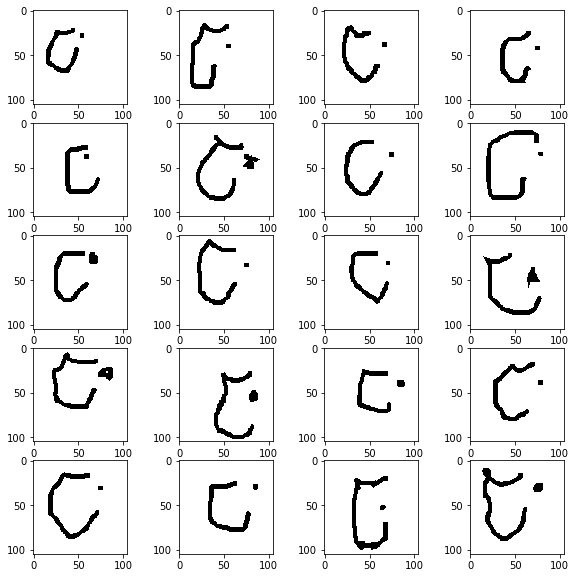

In [27]:
plot_images('train/Arcadian/character03/')
print("Arcadian language, 20 samples of the third character.")

Kannada language, 20 samples of the fifth character.


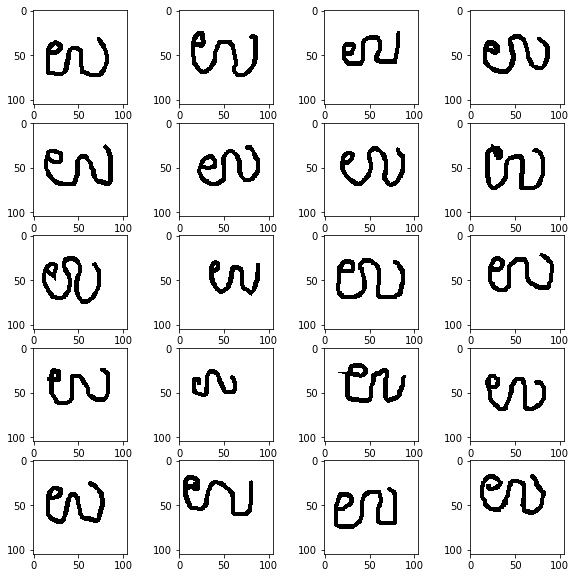

In [28]:
plot_images('test/Kannada/character05/')
print("Kannada language, 20 samples of the fifth character.")

## Training the model on train and test set


 Please refer to 'Helper Functions for returning (key,value) pair arguments (kwargs)' of Helper Functions sections to know the functions used in this section.

### Initialize the model
 

In [17]:
model = OmniglotModel(args['classes'], **model_kwargs(args))

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.


<img src="png.png"></img>

### Training the model

In [18]:
with tf.Session() as sess:
    if not args['pretrained']:
        print('Training...')
        train(sess, model, train_set, test_set, save_dir='checkpoints',**train_kwargs(args))
    else:
        print('Restoring from checkpoint...')
        tf.train.Saver().restore(sess, tf.train.latest_checkpoint(args['checkpoint']))

Training...
batch 0: train=0.050000 test=0.150000
batch 10: train=0.150000 test=0.050000
batch 20: train=0.250000 test=0.050000
batch 30: train=0.300000 test=0.150000
batch 40: train=0.300000 test=0.150000
batch 50: train=0.350000 test=0.300000
batch 60: train=0.250000 test=0.200000
batch 70: train=0.400000 test=0.250000
batch 80: train=0.400000 test=0.150000
batch 90: train=0.450000 test=0.350000
batch 100: train=0.300000 test=0.350000
batch 110: train=0.550000 test=0.200000
batch 120: train=0.400000 test=0.400000
batch 130: train=0.450000 test=0.300000
batch 140: train=0.450000 test=0.600000
batch 150: train=0.500000 test=0.300000
batch 160: train=0.500000 test=0.300000
batch 170: train=0.350000 test=0.300000
batch 180: train=0.200000 test=0.350000
batch 190: train=0.400000 test=0.300000
batch 200: train=0.450000 test=0.150000
batch 210: train=0.600000 test=0.450000
batch 220: train=0.650000 test=0.200000
batch 230: train=0.550000 test=0.100000
batch 240: train=0.550000 test=0.400000

batch 1950: train=0.600000 test=0.700000
batch 1960: train=0.600000 test=0.800000
batch 1970: train=0.700000 test=0.400000
batch 1980: train=0.650000 test=0.700000
batch 1990: train=0.750000 test=0.550000
batch 2000: train=0.550000 test=0.350000
batch 2010: train=0.650000 test=0.500000
batch 2020: train=0.550000 test=0.600000
batch 2030: train=0.600000 test=0.300000
batch 2040: train=0.650000 test=0.550000
batch 2050: train=0.550000 test=0.500000
batch 2060: train=0.600000 test=0.450000
batch 2070: train=0.750000 test=0.750000
batch 2080: train=0.650000 test=0.450000
batch 2090: train=0.650000 test=0.450000
batch 2100: train=0.500000 test=0.550000
batch 2110: train=0.600000 test=0.450000
batch 2120: train=0.700000 test=0.600000
batch 2130: train=0.750000 test=0.600000
batch 2140: train=0.600000 test=0.500000
batch 2150: train=0.850000 test=0.450000
batch 2160: train=0.700000 test=0.500000
batch 2170: train=0.850000 test=0.600000
batch 2180: train=0.650000 test=0.450000
batch 2190: trai

batch 3950: train=0.700000 test=0.600000
batch 3960: train=0.600000 test=0.600000
batch 3970: train=0.650000 test=0.600000
batch 3980: train=0.650000 test=0.500000
batch 3990: train=0.650000 test=0.750000
batch 4000: train=0.600000 test=0.750000
batch 4010: train=0.650000 test=0.550000
batch 4020: train=0.700000 test=0.600000
batch 4030: train=0.600000 test=0.600000
batch 4040: train=0.750000 test=0.650000
batch 4050: train=0.750000 test=0.800000
batch 4060: train=0.550000 test=0.450000
batch 4070: train=0.800000 test=0.450000
batch 4080: train=0.550000 test=0.800000
batch 4090: train=0.850000 test=0.500000
batch 4100: train=0.750000 test=0.750000
batch 4110: train=0.550000 test=0.500000
batch 4120: train=0.600000 test=0.400000
batch 4130: train=0.500000 test=0.550000
batch 4140: train=0.850000 test=0.550000
batch 4150: train=0.650000 test=0.350000
batch 4160: train=0.550000 test=0.450000
batch 4170: train=0.700000 test=0.500000
batch 4180: train=0.700000 test=0.800000
batch 4190: trai

batch 5950: train=0.800000 test=0.600000
batch 5960: train=0.600000 test=0.550000
batch 5970: train=0.700000 test=0.550000
batch 5980: train=0.650000 test=0.450000
batch 5990: train=0.750000 test=0.400000
batch 6000: train=0.750000 test=0.600000
batch 6010: train=0.750000 test=0.800000
batch 6020: train=0.700000 test=0.650000
batch 6030: train=0.600000 test=0.650000
batch 6040: train=0.850000 test=0.800000
batch 6050: train=0.800000 test=0.650000
batch 6060: train=0.600000 test=0.700000
batch 6070: train=0.650000 test=0.400000
batch 6080: train=0.700000 test=0.750000
batch 6090: train=0.550000 test=0.600000
batch 6100: train=0.800000 test=0.550000
batch 6110: train=0.800000 test=0.650000
batch 6120: train=0.700000 test=0.700000
batch 6130: train=0.700000 test=0.800000
batch 6140: train=0.750000 test=0.550000
batch 6150: train=0.750000 test=0.450000
batch 6160: train=0.750000 test=0.750000
batch 6170: train=0.800000 test=0.400000
batch 6180: train=0.600000 test=0.500000
batch 6190: trai

batch 7950: train=0.700000 test=0.800000
batch 7960: train=0.650000 test=0.700000
batch 7970: train=1.000000 test=0.700000
batch 7980: train=0.750000 test=0.650000
batch 7990: train=0.750000 test=0.600000
batch 8000: train=0.800000 test=0.750000
batch 8010: train=0.650000 test=0.700000
batch 8020: train=0.700000 test=0.800000
batch 8030: train=0.550000 test=0.750000
batch 8040: train=0.550000 test=0.750000
batch 8050: train=0.700000 test=0.700000
batch 8060: train=0.650000 test=0.650000
batch 8070: train=0.650000 test=0.700000
batch 8080: train=0.800000 test=0.700000
batch 8090: train=0.950000 test=0.650000
batch 8100: train=0.750000 test=0.700000
batch 8110: train=0.750000 test=0.750000
batch 8120: train=0.650000 test=0.700000
batch 8130: train=0.800000 test=0.550000
batch 8140: train=0.850000 test=0.650000
batch 8150: train=0.750000 test=0.750000
batch 8160: train=0.700000 test=0.600000
batch 8170: train=0.750000 test=0.500000
batch 8180: train=0.650000 test=0.800000
batch 8190: trai

batch 9950: train=0.850000 test=0.800000
batch 9960: train=0.800000 test=0.750000
batch 9970: train=0.750000 test=0.650000
batch 9980: train=0.850000 test=0.850000
batch 9990: train=0.800000 test=0.550000
batch 10000: train=0.850000 test=0.800000
batch 10010: train=0.900000 test=0.850000
batch 10020: train=0.800000 test=0.750000
batch 10030: train=0.950000 test=0.650000
batch 10040: train=0.850000 test=0.800000
batch 10050: train=0.800000 test=0.450000
batch 10060: train=0.800000 test=0.750000
batch 10070: train=0.950000 test=0.750000
batch 10080: train=0.750000 test=0.450000
batch 10090: train=0.850000 test=0.900000
batch 10100: train=0.700000 test=0.750000
batch 10110: train=0.850000 test=0.600000
batch 10120: train=0.750000 test=0.600000
batch 10130: train=0.750000 test=0.800000
batch 10140: train=0.850000 test=0.600000
batch 10150: train=0.950000 test=0.600000
batch 10160: train=0.850000 test=0.800000
batch 10170: train=0.800000 test=0.800000
batch 10180: train=0.900000 test=0.4500

batch 11910: train=0.800000 test=0.750000
batch 11920: train=1.000000 test=0.750000
batch 11930: train=0.750000 test=0.850000
batch 11940: train=0.750000 test=0.850000
batch 11950: train=0.900000 test=0.650000
batch 11960: train=0.800000 test=0.800000
batch 11970: train=0.750000 test=0.850000
batch 11980: train=0.800000 test=0.750000
batch 11990: train=0.750000 test=0.800000
batch 12000: train=0.900000 test=0.700000
batch 12010: train=0.700000 test=0.800000
batch 12020: train=0.850000 test=0.650000
batch 12030: train=0.800000 test=0.900000
batch 12040: train=0.750000 test=0.750000
batch 12050: train=0.750000 test=0.600000
batch 12060: train=0.800000 test=0.700000
batch 12070: train=0.900000 test=0.600000
batch 12080: train=0.800000 test=0.650000
batch 12090: train=0.900000 test=0.550000
batch 12100: train=0.900000 test=0.650000
batch 12110: train=0.850000 test=0.700000
batch 12120: train=0.800000 test=0.650000
batch 12130: train=0.950000 test=0.650000
batch 12140: train=0.850000 test=0

batch 13870: train=0.850000 test=0.800000
batch 13880: train=0.750000 test=0.850000
batch 13890: train=0.850000 test=0.750000
batch 13900: train=0.650000 test=0.800000
batch 13910: train=0.850000 test=0.850000
batch 13920: train=0.700000 test=0.800000
batch 13930: train=0.800000 test=0.650000
batch 13940: train=0.800000 test=0.750000
batch 13950: train=0.950000 test=0.900000
batch 13960: train=0.700000 test=0.750000
batch 13970: train=0.800000 test=0.750000
batch 13980: train=0.700000 test=0.650000
batch 13990: train=0.950000 test=0.750000
batch 14000: train=0.800000 test=0.650000
batch 14010: train=0.850000 test=0.750000
batch 14020: train=0.950000 test=0.900000
batch 14030: train=0.800000 test=0.700000
batch 14040: train=0.650000 test=0.800000
batch 14050: train=0.900000 test=0.550000
batch 14060: train=0.850000 test=0.900000
batch 14070: train=0.850000 test=0.550000
batch 14080: train=0.850000 test=0.700000
batch 14090: train=0.800000 test=0.700000
batch 14100: train=0.800000 test=0

batch 15830: train=0.750000 test=0.750000
batch 15840: train=0.950000 test=0.550000
batch 15850: train=0.800000 test=0.600000
batch 15860: train=0.800000 test=0.800000
batch 15870: train=0.750000 test=0.650000
batch 15880: train=1.000000 test=0.800000
batch 15890: train=0.850000 test=0.750000
batch 15900: train=0.750000 test=0.750000
batch 15910: train=0.900000 test=0.800000
batch 15920: train=0.800000 test=0.700000
batch 15930: train=0.900000 test=0.750000
batch 15940: train=0.650000 test=0.850000
batch 15950: train=0.850000 test=0.750000
batch 15960: train=0.750000 test=0.800000
batch 15970: train=0.900000 test=0.650000
batch 15980: train=0.800000 test=0.750000
batch 15990: train=0.850000 test=0.800000
batch 16000: train=0.950000 test=0.800000
batch 16010: train=0.850000 test=0.700000
batch 16020: train=1.000000 test=0.850000
batch 16030: train=0.800000 test=0.750000
batch 16040: train=0.850000 test=0.600000
batch 16050: train=0.750000 test=0.400000
batch 16060: train=0.850000 test=0

batch 17790: train=0.850000 test=0.750000
batch 17800: train=0.800000 test=0.800000
batch 17810: train=0.850000 test=0.850000
batch 17820: train=0.950000 test=0.800000
batch 17830: train=0.800000 test=0.800000
batch 17840: train=0.950000 test=0.650000
batch 17850: train=0.850000 test=0.600000
batch 17860: train=0.900000 test=0.850000
batch 17870: train=0.900000 test=0.800000
batch 17880: train=0.900000 test=0.900000
batch 17890: train=0.950000 test=0.750000
batch 17900: train=0.800000 test=0.800000
batch 17910: train=0.900000 test=0.900000
batch 17920: train=0.850000 test=0.750000
batch 17930: train=0.950000 test=0.700000
batch 17940: train=1.000000 test=0.700000
batch 17950: train=0.750000 test=0.700000
batch 17960: train=1.000000 test=0.750000
batch 17970: train=0.900000 test=0.850000
batch 17980: train=0.900000 test=0.800000
batch 17990: train=0.700000 test=0.850000
batch 18000: train=0.950000 test=0.800000
batch 18010: train=0.800000 test=0.850000
batch 18020: train=0.950000 test=0

batch 19750: train=0.800000 test=0.700000
batch 19760: train=1.000000 test=0.600000
batch 19770: train=0.850000 test=0.850000
batch 19780: train=0.800000 test=0.850000
batch 19790: train=0.800000 test=0.700000
batch 19800: train=0.850000 test=0.900000
batch 19810: train=0.950000 test=0.700000
batch 19820: train=0.850000 test=0.750000
batch 19830: train=0.900000 test=0.950000
batch 19840: train=0.950000 test=0.900000
batch 19850: train=0.900000 test=0.950000
batch 19860: train=0.900000 test=0.850000
batch 19870: train=0.700000 test=0.650000
batch 19880: train=0.900000 test=0.700000
batch 19890: train=0.900000 test=0.700000
batch 19900: train=0.900000 test=0.750000
batch 19910: train=0.850000 test=0.750000
batch 19920: train=0.900000 test=0.800000
batch 19930: train=0.900000 test=0.800000
batch 19940: train=0.850000 test=0.800000
batch 19950: train=0.900000 test=0.750000
batch 19960: train=0.850000 test=0.850000
batch 19970: train=0.900000 test=0.550000
batch 19980: train=0.800000 test=0

### After training,close the session.

In [24]:
sess.close()

### Plotting the train and test accuracies after 20,000 epochs
    
#### Train Accuracy
<img src="train.png" style="display:inline;"></img>
#### Test Accuracy
<img src="test.png" style="display:inline;"></img>
#### Train vs Test
<img src="train_test.png" style="display:inline;"></img>

### Training accuracy for 100 random one-shot 20-way tasks generated from training data

In [25]:
args['eval_samples'] = 100
eval_kwargs = evaluate_kwargs(args)
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('checkpoints/model.ckpt-19999.meta')
    saver.restore(sess, 'checkpoints/model.ckpt-19999')
    print('Train accuracy: ' + str(evaluate(sess, model, train_set, **eval_kwargs)))

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-19999
In Evaluate
Train accuracy: 0.8715


### Testing accuracy for 100 random one-shot 20-way tasks generated from testing data

In [296]:
args['eval_samples'] = 100
eval_kwargs = evaluate_kwargs(args)
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('checkpoints/model.ckpt-19999.meta')
    saver.restore(sess, 'checkpoints/model.ckpt-19999')
    print('Test accuracy: ' + str(evaluate(sess, model, test_set, **eval_kwargs)))

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-19999
In Evaluate
Test accuracy: 0.7925


In [295]:
sess.close()

## The n-shot, k-way task

The ability of an algorithm to perform few-shot learning is typically measured by its performance on n-shot, k-way tasks. These are run as follows:

>A model is given a query sample belonging to a new, previously unseen class

>It is also given a support set, S, consisting of n examples each from k different unseen classes

>The algorithm then has to determine which of the support set classes the query sample belongs to

We are using one-shot 20-way tasks.

### How to generate n-shot, k-way tasks?

In [114]:
#Create a fucntion which uses the make_one_shot fucntion of FOML to return predictions and samples of the given dataset.

def create_one_shot(sess,
             model,
             dataset,
             num_classes,
             num_shots,
             eval_inner_batch_size,
             eval_inner_iters,
             replacement,
             num_samples,
             transductive,
             model_fn,
             weight_decay_rate):
    """
    Create a few-shot tasks on a dataset.
    """
    foml = model_fn(sess,
                         transductive=transductive,
                         pre_step_op=weight_decay(weight_decay_rate))
    pred_sample = foml.make_one_shot(dataset, model.input_ph, model.label_ph,
                                          model.minimize_op, model.predictions,
                                          num_classes=num_classes, num_shots=num_shots,
                                          inner_batch_size=eval_inner_batch_size,
                                          inner_iters=eval_inner_iters, replacement=replacement)
    return pred_sample

#### Call that function to generate one-shot 20-way tasks and assign them.

In [200]:
eval_kwargs = evaluate_kwargs(args)
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('checkpoints/model.ckpt-19999.meta')
    saver.restore(sess, 'checkpoints/model.ckpt-19999')
    prediction_samples = create_one_shot(sess,model,test_set, **eval_kwargs)
prediction = []
samples = []
for pred, sample in prediction_samples:
    prediction.append(pred)
    samples.append(sample)

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-19999


### Plotting one-shot 20-way tasks

#### Helper Functions to concatenate support set into one plot and to plot the tasks.

In [303]:
def concat_images(samples):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc = len(samples)
    h , w = samples[0][0].shape
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros(((n-1)*w,n*h))
    x = 0
    y = 0
    for i in range(len(samples)):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = samples[i][0]
        y += 1
        if y >= n and x <= (n-1):
            y = 0
            x += 1
    return img

def plot_oneshot_task(prediction , samples):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    p = samples[prediction][0]
    ax1.set_title('Sample')
    ax2.set_title('Support Set')
    ax1.matshow(p, cmap='gray')
    img = concat_images(samples)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

#### Take a random prediction and plot the sample and support set

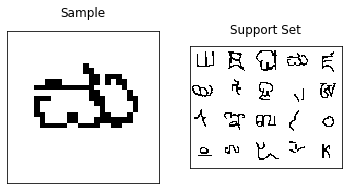

In [304]:
x = random.randint(0,len(prediction)-1)
plot_oneshot_task(prediction[x],samples)

In [199]:
sess.close()

### Validation 

Given this sample from unseen data and support set to the model, it determines the class of the query sample from the support set

### Principal Component Analysis  (20-dimensional data)

Please refer to 'Helper function to plot images in a row' of Helper Functions sections to know the functions used in this section.

256 points plotted over 20-dimensions


- Total Variance for Fig 1 (Dense/Kernel): 42.7%
- Total Variance for Fig 2 (Dense/Kernel/Adam): 99.2%
- Total Variance for Fig 3 (Dense/Kernel/Adam_1): 98.8%

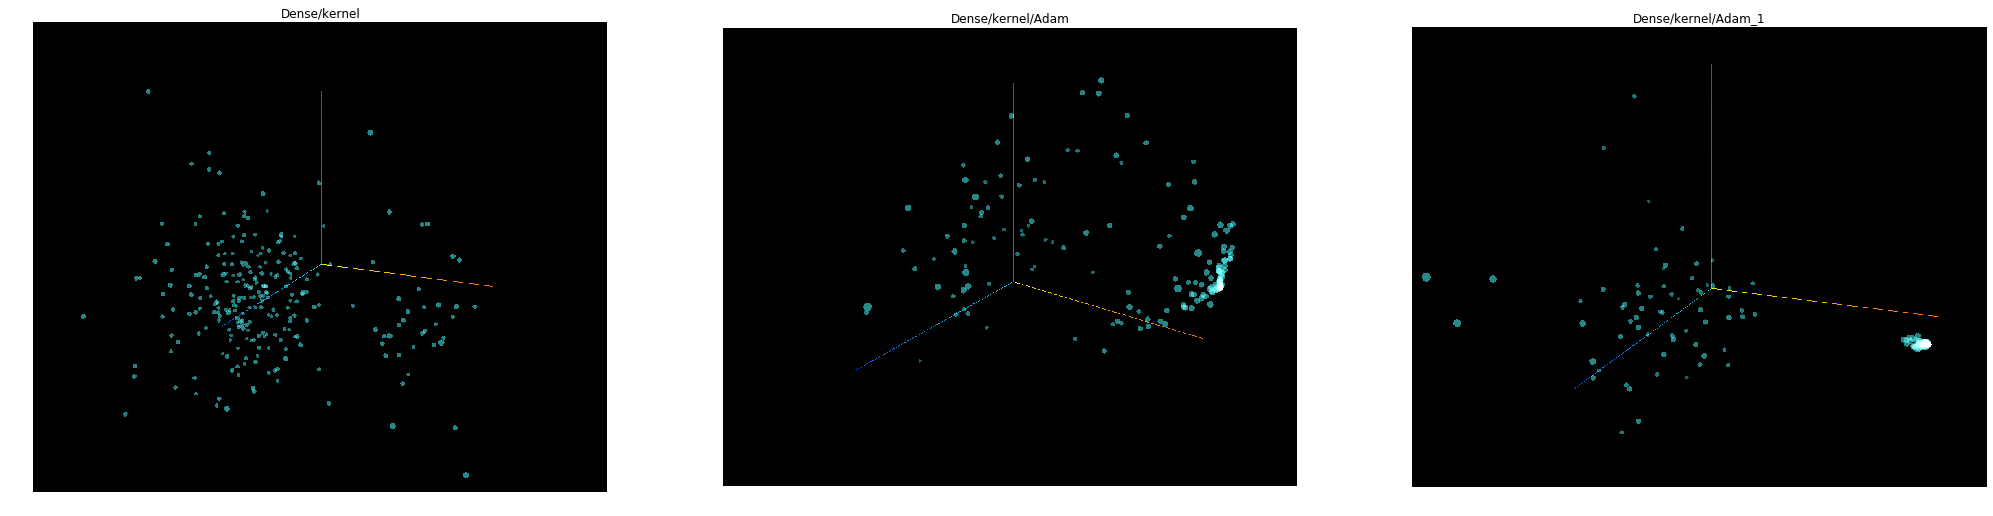

In [329]:
img_A = cv2.imread("B_A.png")
img_B = cv2.imread("B_B.png")
img_C = cv2.imread("B_C.png")

titles = ["Dense/kernel", 
          "Dense/kernel/Adam", 
          "Dense/kernel/Adam_1"]
images = [img_A,img_B,img_C]

grid_display(images, titles, 3, (35,35))

## How did the model perform?

### State-of-the-art solution

The state-of-the-art solution 'Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks' on Few-Shot learning presented us with an accuracy of 98.7%. Taking into consideration the number of epochs trained and the GPU availability, I trained for 20,000 epochs and achieved an accuracy of 87.15%. If the model had trained for more epochs, I guess we might nearly achieve the state-of-the-art accuracy presented in ICML 2017. By Chelsea Finn • Pieter Abbeel • Sergey Levine


### Initial training algorithm (Scaled updates)

Intially in the train_step function of class FOML, model state variables are updated from the last backup and this session's state variables, pushing the difference into an updates array and then average of these updates are scaled with meta step size and adding then to the old varibales of the model. 

But training on this way of train_step implementation, the accuracy was not improving over a lot of epochs. Please see the train vs test accuracy of scaled updates type of training

### Train vs Test Accuracy (Scaled Updates)

<img src="train_test_su.png">


As you can see over 4k epoch (12k - 16k), accuracy was not improving, so I had to stop training and tweak the train_step implementation.

### Tweaked Training algorithm (Interpolating updates)

As present, the model was trained on this tweaked train_step function implementation. We achieved an accuracy of 87.15% over 20,000 epochs. 

## Further Improvements

* Training the present model on more epochs,on a better GPU to nearly achieve the state-of-the-art solution accuracy
* Refering to a paper [How to Train your MAML](https://openreview.net/forum?id=HJGven05Y7) by Antreas Antoniou, Harrison Edwards, Amos Storkey, we get more insights on the problems of vanilla MAML.
* This paper proposes several improvements for the MAML algorithm that improve its stability and performance.